<a href="https://colab.research.google.com/github/fpichi/gca-rom/blob/main/notebook/07_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [12]:
# Install PyTorch
try:
  import torch
except ImportError:
  !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
  import torch

In [13]:
# Install PyG
try:
  import torch_geometric
except ImportError:
  !pip3 install torch_geometric
  import torch_geometric

In [14]:
# Clone and import gca-rom
import sys
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/fpichi/gca-rom.git
    sys.path.append('gca-rom')
else:
    sys.path.append('./..')

from gca_rom import network, pde, loader, plotting, preprocessing, training, initialization, testing, error, gui


In [15]:
import numpy as np
from itertools import product

# Define PDE problem

- the pde class sets predefined variables for each equation specified in the paper
- gui class has a gui that lets the user set all the hyperparameters
- that is then simply stored in a HyperParams object that has all the hyperparameters. Not sure why they used an object here though

In [16]:
problem_name, variable, mu_space, n_param, dim_pde, n_comp = pde.problem(7)
argv = gui.hyperparameters_selection(problem_name, variable, n_param, n_comp)
HyperParams = network.HyperParams(argv)
HyperParams.__dict__

{'net_name': 'diffusion',
 'variable': 'U',
 'scaling_type': 4,
 'scaler_number': 3,
 'scaler_name': 'standard',
 'skip': 1,
 'rate': 30,
 'sparse_method': 'L1_mean',
 'ffn': 200,
 'nodes': 50,
 'bottleneck_dim': 15,
 'lambda_map': 10.0,
 'in_channels': 3,
 'seed': 10,
 'tolerance': 1e-06,
 'learning_rate': 0.001,
 'map_act': 'tanh',
 'layer_vec': [2, 50, 50, 50, 50, 15],
 'net_run': '_standard',
 'weight_decay': 1e-05,
 'max_epochs': 5000,
 'comp': 1,
 'hidden_channels': [1, 1, 1],
 'miles': [],
 'gamma': 0.0001,
 'num_nodes': 0,
 'conv': 'GMMConv',
 'ae_act': 'elu',
 'batch_size': inf,
 'minibatch': False,
 'net_dir': './diffusion/_standard/U_diffusion_lmap10.0_btt15_seed10_lv4_hc3_nd50_ffn200_skip1_lr0.001_sc4_rate30_convGMMConv/',
 'cross_validation': True}

In [17]:
pde.problem(7)

('diffusion',
 'U',
 [array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6,
         2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. ]),
  array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
         0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
         0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
         0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])],
 2,
 2,
 1)

# Initialize device and set reproducibility

- simply setting the device, seed and path

In [18]:
device = initialization.set_device()
initialization.set_reproducibility(HyperParams)
initialization.set_path(HyperParams)

Device used:  cpu


# Load dataset

Using the loader class to load in a matlab file (pretty simple, just taking the variables and loading them in as tensors)

# preprocessing graph_dataset function
- takes in the dataset object along with the hyperparams object
- extracts xx and yy from the dataset
- creates vector xyz such that xyz = [xx, yy]
- extracts zz if its 3D and adds it to xyz
- if the comp is 1 (not sure what cpmp means in this context) it sets 1 variable, or it sets var to be the combination of two variables var1 and var2 

    ### Processing dataset
    - the number of nodes seems to be the shape of the first element of the variable var
    - the number of graphs seems to be the shape of the second element of var

    ### Dataset splitting
    - split the dataset with the (rate * number of graphs) as the number of training sims and the remaining as the number of testing sims. The total sims is the number of graphs
    - they are then randomly split into the sizes

    ### Scaling
    - in this case comp is 1
    - uses the tensor_scaling function from scaling

        ##### Tensor scaling function:
        - essentially this applies either MinMaxScaler, RobustScaler or StandardScaler from sklearn. 
        - in this case scaling_type = 4 and scaler_number = 3, so we use the standard scaler
    - we scale "all" and the test data
    


In [24]:
import importlib
importlib.reload(preprocessing)

if 'google.colab' in str(get_ipython()):
    dataset_dir = '/content/gca-rom/dataset/'+problem_name+'_unstructured.mat'
else:
    dataset_dir = '../dataset/'+problem_name+'_unstructured.mat'
dataset = loader.LoadDataset(dataset_dir, variable, dim_pde, n_comp)

graph_loader, train_loader, test_loader, \
    val_loader, scaler_all, scaler_test, xyz, VAR_all, VAR_test, \
        train_trajectories, test_trajectories = preprocessing.graphs_dataset(dataset, HyperParams)

params = torch.tensor(np.array(list(product(*mu_space))))
params = params.to(device)

torch.Size([933, 400])
Number of nodes processed:  933
Number of graphs processed:  400
Length of train dataset:  120
Length of test dataset:  280


# Define the architecture

In [25]:
model = network.Net(HyperParams)
model = model.to(device)
if 'google.colab' in str(get_ipython()):
  torch.set_default_dtype(torch.float32)
optimizer = torch.optim.Adam(model.parameters(), lr=HyperParams.learning_rate, weight_decay=HyperParams.weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=HyperParams.miles, gamma=HyperParams.gamma)

# Train or load a pre-trained network

In [26]:
try:
    model.load_state_dict(torch.load(HyperParams.net_dir+HyperParams.net_name+HyperParams.net_run+'.pt'))
    print('Loading saved network')
except FileNotFoundError:
    print('Training network')
    training.train(model, optimizer, device, scheduler, params, train_loader, test_loader, train_trajectories, test_trajectories, HyperParams)

Loading saved network


# Evaluate the model

In [13]:
model.to("cpu")
params = params.to("cpu")
vars = "GCA-ROM"
results, latents_map, latents_gca = testing.evaluate(VAR_all, model, graph_loader, params, HyperParams, range(params.shape[0]))

100%|██████████| 400/400 [00:01<00:00, 354.07it/s]


# Plot the results

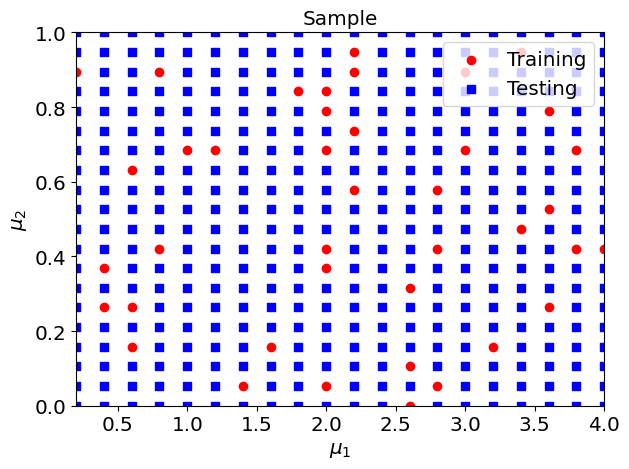

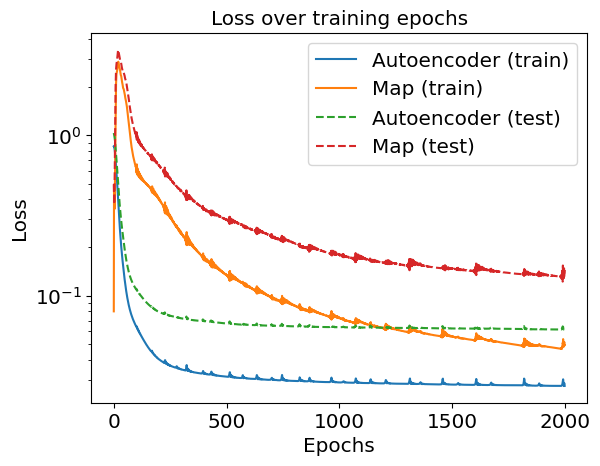

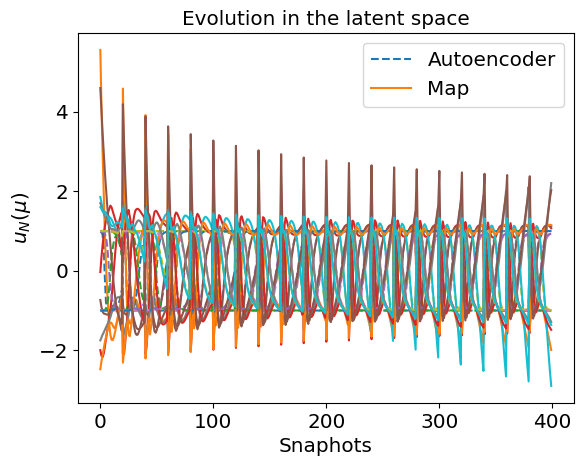

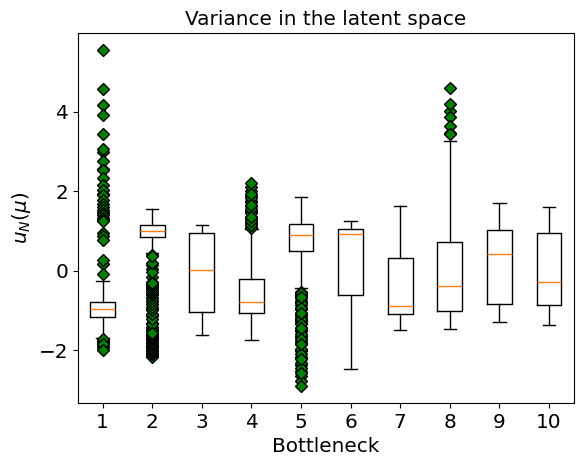

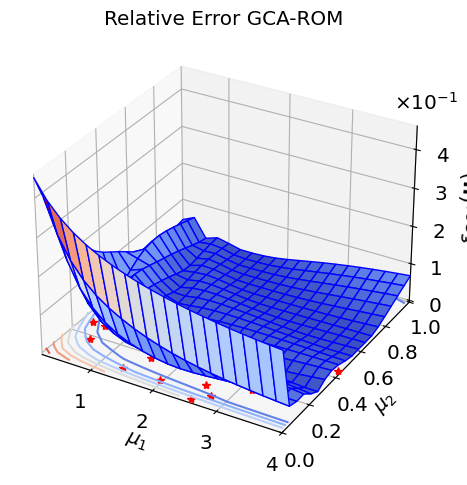

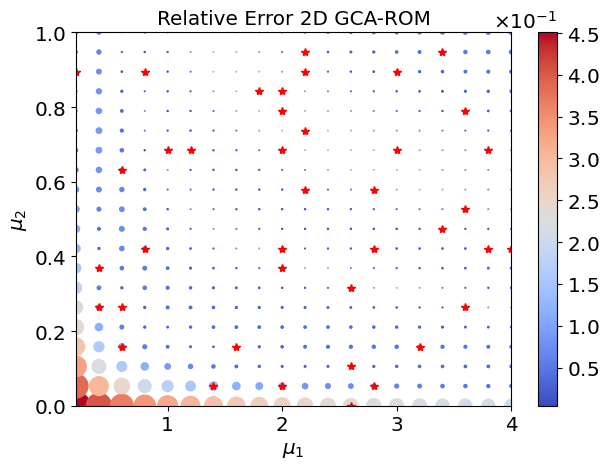

In [14]:
plotting.plot_sample(HyperParams, mu_space, params, train_trajectories, test_trajectories)
plotting.plot_loss(HyperParams)
plotting.plot_latent(HyperParams, latents_map, latents_gca)

plotting.plot_error(results, VAR_all, scaler_all, HyperParams, mu_space, params, train_trajectories, vars)
plotting.plot_error_2d(results, VAR_all, scaler_all, HyperParams, mu_space, params, train_trajectories, vars)

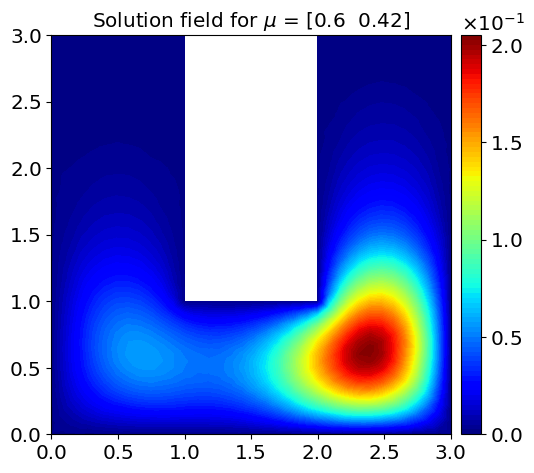

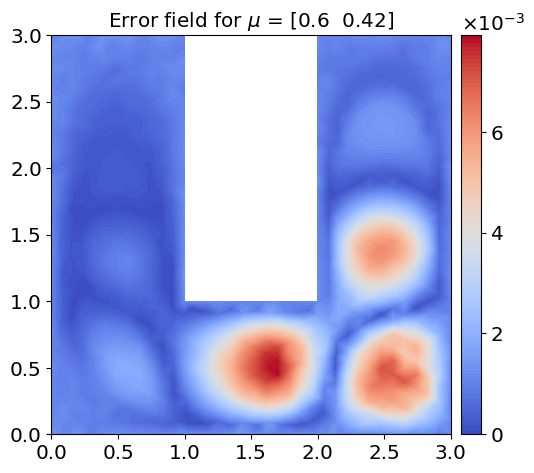

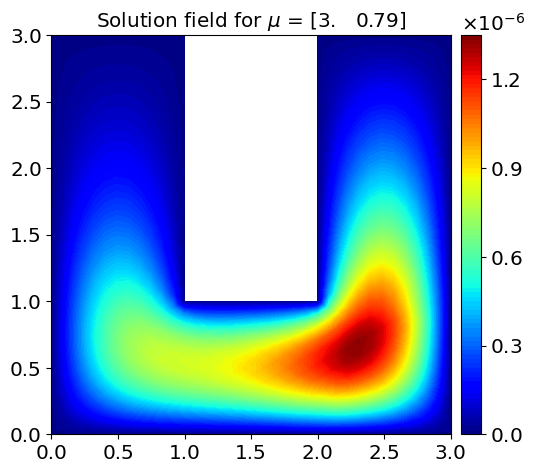

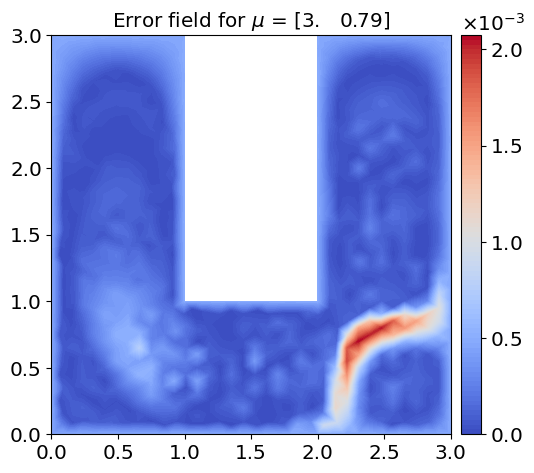

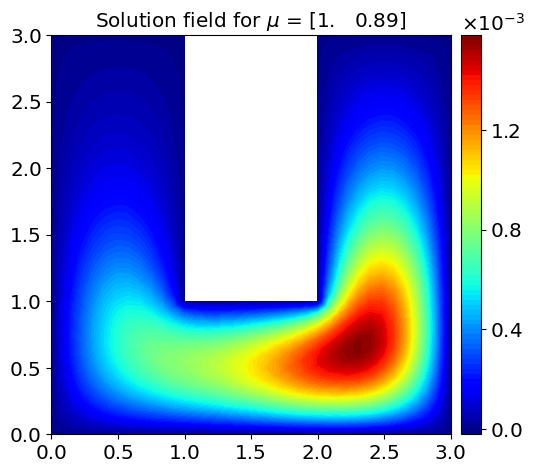

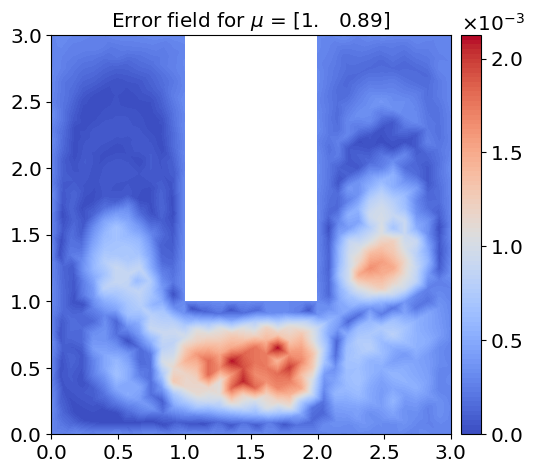

In [16]:
N = 3
snapshots = np.arange(params.shape[0]).tolist()
np.random.shuffle(snapshots)
for SNAP in snapshots[0:N]:
    plotting.plot_fields(SNAP, results, scaler_all, HyperParams, dataset, xyz, params)
    plotting.plot_error_fields(SNAP, results, VAR_all, scaler_all, HyperParams, dataset, xyz, params)

# Print the errors on the testing set

100%|██████████| 360/360 [00:00<00:00, 1226.15it/s]



Maximum absolute error for field GCA-ROM =  9.175196315608297
Mean absolute error for field GCA-ROM =  0.32053908690273264
Minimum absolute error for field GCA-ROM =  9.371868313617352e-10

Maximum relative error for field GCA-ROM =  0.44638640165160826
Mean relative error for field GCA-ROM =  0.049234964084783804
Minimum relative error for field GCA-ROM =  0.004635103518447297


<Figure size 640x480 with 0 Axes>

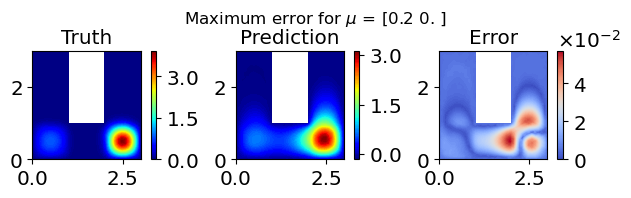

In [17]:
results_test, _, _ = testing.evaluate(VAR_test, model, val_loader, params, HyperParams, test_trajectories)

error_abs, norm = error.compute_error(results_test, VAR_test, scaler_test, HyperParams)
error.print_error(error_abs, norm, vars)
error.save_error(error_abs, norm, HyperParams, vars)

plotting.plot_comparison_fields(results, VAR_all, scaler_all, HyperParams, dataset, xyz, params)